# CNN for AED with Keras/TensorFlow

Date: November 6, 2018

Neural network: three convolution layers and three fully connected layers

Classification of acoustic events:

- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music

## Preparing data set for CNN

In [29]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#DATA_FOLDER = '/content/gdrive/My Drive/acoustic_event_detection/data/'
DATA_FOLDER = '../oscilloscope/data/data_music/'

FILTERS=40
FILES = 100
TRAINING_FILES = 67
TEST_FILES = FILES - TRAINING_FILES

In [30]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import os
import sklearn.preprocessing as pp

In [31]:
import glob

data_files = glob.glob(DATA_FOLDER+'*mel_spectrogram*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

        data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*mel_spectrogram*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

LENGTH=64
a1, a2 = 0,  FILTERS*64
b1, b2 = FILTERS*64, FILTERS*64*2
c1, c2 = FILTERS*64*2, FILTERS*64*3

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[a1:a2]['magnitude'].values)
        img2 = pp.scale(df[b1:b2]['magnitude'].values)
        img3 = pp.scale(df[c1:c2]['magnitude'].values)
        training_set.append((img1, class_number))
        training_set.append((img2, class_number))
        training_set.append((img3, class_number))
    files = v[1]
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[a1:a2]['magnitude'].values)
        img2 = pp.scale(df[b1:b2]['magnitude'].values)
        img3 = pp.scale(df[c1:c2]['magnitude'].values)
        test_set.append((img1, class_number))
        test_set.append((img2, class_number))
        test_set.append((img3, class_number))

random.shuffle(training_set)
random.shuffle(test_set)

class_labels = []

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k ))
    class_labels.append(k)

import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: blues_harp
1: classical_guitar
2: framenco_guitar
3: piano
4: tin_whistle


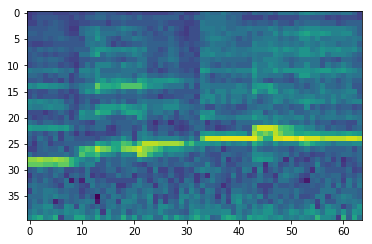

In [32]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data, dtype='float32').reshape((TRAINING_FILES*5*3, LENGTH, FILTERS, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data, dtype='float32').reshape((TEST_FILES*5*3, LENGTH, FILTERS, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(np.rot90(train_data[0, :,:,0]))

### CNN model

In [13]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(LENGTH, FILTERS, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 36, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 18, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 7, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2912)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2912)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                186432    
__________

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

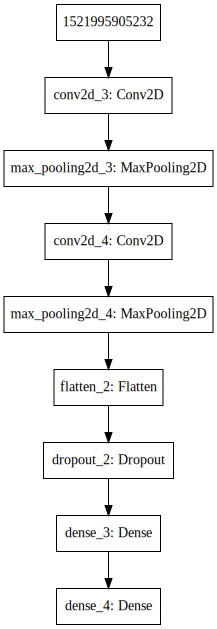

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [16]:
EPOCHS = 10
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels), batch_size=10)

Train on 1005 samples, validate on 495 samples
Epoch 1/10
1005/1005 [==============================] - 19s 19ms/step - loss: 0.7062 - acc: 0.7343 - val_loss: 0.3311 - val_acc: 0.8747
Epoch 2/10
1005/1005 [==============================] - 18s 18ms/step - loss: 0.3641 - acc: 0.8627 - val_loss: 0.2826 - val_acc: 0.8970
Epoch 3/10
1005/1005 [==============================] - 18s 18ms/step - loss: 0.2817 - acc: 0.8756 - val_loss: 0.2872 - val_acc: 0.8788
Epoch 4/10
1005/1005 [==============================] - 18s 18ms/step - loss: 0.2647 - acc: 0.9045 - val_loss: 0.2995 - val_acc: 0.8929
Epoch 5/10
1005/1005 [==============================] - 18s 18ms/step - loss: 0.2362 - acc: 0.9204 - val_loss: 0.2757 - val_acc: 0.9071
Epoch 6/10
1005/1005 [==============================] - 18s 18ms/step - loss: 0.1924 - acc: 0.9373 - val_loss: 0.5348 - val_acc: 0.8525
Epoch 7/10
1005/1005 [==============================] - 20s 19ms/step - loss: 0.1888 - acc: 0.9254 - val_loss: 0.4171 - val_acc: 0.9051
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


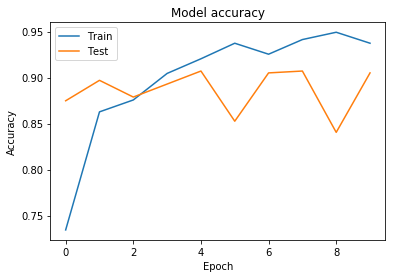

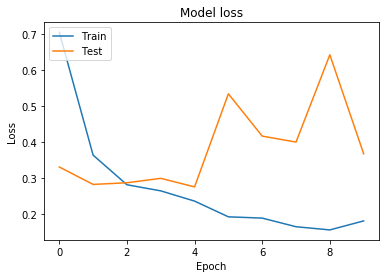

In [17]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [18]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_aed_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [19]:
del model
model = models.load_model(filename)

## Confirmation

In [20]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(1005, 64, 40, 1)

In [21]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [22]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

'blues_harp'

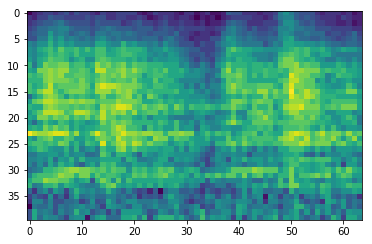

In [23]:
image_number = 22
plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

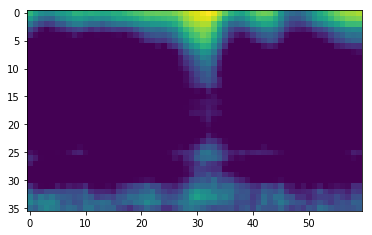

In [24]:
plt.imshow(np.rot90(activations[0][image_number,:,:,10]))

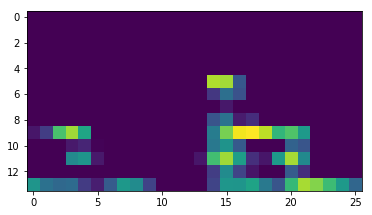

In [25]:
plt.imshow(np.rot90(activations[2][image_number,:,:,1]))

In [26]:
class_labels

['blues_harp', 'classical_guitar', 'framenco_guitar', 'piano', 'tin_whistle']

In [27]:
(activations[-1][:10]*100).astype(int)

array([[  0,   0,   0,  99,   0],
       [  0,   0,   0,   0, 100],
       [  0,   0,   0,  99,   0],
       [  0,   0,   0,   0, 100],
       [  0,   0,  99,   0,   0],
       [  0,   0,   0,   0, 100],
       [  0,   0,   0,   0, 100],
       [  0,   8,  90,   0,   0],
       [  0,   0,   0,   0, 100],
       [  0,   3,   0,  96,   0]])

In [28]:
test_labels[:10].astype(int)

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])